In [1]:
from copy import deepcopy
import json
import glob
import os
import sys
import time
import argparse
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.font_manager import FontProperties
import cv2
import pandas as pd
import matplotlib.font_manager

In [2]:
plt.rcParams["font.family"] = "serif"

In [3]:
iou_thr = 0.5

In [4]:
main_dir = os.path.dirname(os.getcwd())

In [5]:
main_dir

'/home/vgoncalves/personal-git/people-detection-compare'

In [6]:
sys.path.append(os.path.join(main_dir, 'average_precision/'))

In [7]:
from calculate_mean_ap import get_avg_precision_at_iou, plot_pr_curve, simple_precision_recall

In [8]:
moving_ground_truth_boxes = main_dir + '/resources/virat_dataset/VIRAT_videos_moving_ground_truth_boxes.json'
all_ground_truth_boxes = main_dir + '/resources/virat_dataset/VIRAT_videos_ground_truth_boxes.json'   

In [11]:
with open(moving_ground_truth_boxes) as infile:
    moving_gt_boxes = json.load(infile)
    
with open(all_ground_truth_boxes) as infile:
    all_gt_boxes = json.load(infile)

In [12]:
# COLORS = [
#     '#1f77b4', '#aec7e8', '#ff7f0e', '#ffbb78', '#2ca02c',
#     '#98df8a', '#d62728', '#ff9896', '#9467bd', '#c5b0d5',
#     '#8c564b', '#c49c94', '#e377c2', '#f7b6d2', '#7f7f7f',
#     '#c7c7c7', '#bcbd22', '#dbdb8d', '#17becf', '#9edae5']


COLORS = [
    '#bada55','#ff0000','#ff80ed','#5ac18e','#ffa500','#660066','#c7c7c7','#17becf']

In [56]:
name_map = {'haar_confidence': 'Haar Cascades',
           'hog_confidence': 'HOG',
            'faster_rcnn': 'Faster R-CNN',
           'yolo': 'YOLO',
           'mobile_ssd': 'Mobile SSD'
           }

pickle_map = {'haar_confidence': 'haar_normalization_round',
           'hog_confidence': 'hog_normalization_round',
              'faster_rcnn':'faster_rcnn',
           'yolo': 'yolo_darknet_416',
           'mobile_ssd': 'mobile_ssd_normalization_round'
             }

#AS técnicas estavam resultando em um mAP igual por conta da existencia de muitos niveis de confianca, dessa forma foi necessário um ajuste manual
manual_map_dict = {'haar_confidence': 
                   {'all': 0.07727272727272727 * 100, #0.85/11
                    'small': 0.0909 * 100, #1/11
                    'medium': 0.13973043293765564 * 100,
                    'large': 0.1319 * 100, 
                   },
                   'hog_confidence': 
                   {'all': 0.08 * 100, #0.88/11
                    'small': 0,
                    'medium': 0.0909 * 100,
                    'large': 0.1911 * 100, 
                   },
                   'faster_rcnn': 
                   {'all':  0.0904 * 100, # 0.995/11
                    'small': 0,
                    'medium': 0.0909 * 100, # 0.984/11
                    'large': 0.4619 * 100
                   },
                   'yolo': 
                   {'all': 0.2257 * 100,
                    'small': 0.0106 * 100,
                    'medium': 0.2209 * 100,
                    'large': 0.7787 * 100, 
                   },
                   'mobile_ssd': 
                   {'all': 0.081818 * 100, # 0.9/11
                    'small': 0,
                    'medium': 0.0894545 * 100, # 0.984/11
                    'large': 0.2071 * 100, 
                   }
                   
}

In [57]:
manual_map_dict

{'faster_rcnn': {'all': 9.04, 'large': 46.19, 'medium': 9.09, 'small': 0},
 'haar_confidence': {'all': 7.727272727272727,
  'large': 13.19,
  'medium': 13.973043293765564,
  'small': 9.09},
 'hog_confidence': {'all': 8.0, 'large': 19.11, 'medium': 9.09, 'small': 0},
 'mobile_ssd': {'all': 8.1818,
  'large': 20.71,
  'medium': 8.945450000000001,
  'small': 0},
 'yolo': {'all': 22.57,
  'large': 77.86999999999999,
  'medium': 22.09,
  'small': 1.06}}

In [54]:
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False

## Dataset description

In [15]:
videos_path = os.path.join(main_dir,'resources/virat_dataset/')

with open(os.path.join(videos_path, 'videos_to_process.txt')) as f:
    video_list = f.read().splitlines()

In [16]:
video_name_list = [x.split('.')[0] for x in video_list]

video_dict = {}
total_frames_all_videos = 0



for video_name in video_name_list:
    video_file_path = os.path.join(videos_path,video_name +  '.mp4')
    vs = cv2.VideoCapture(video_file_path)  # Video
    num_frames = int(vs.get(cv2.CAP_PROP_FRAME_COUNT))
    total_frames_all_videos += num_frames


In [17]:
total_frames_all_videos

158532

In [16]:
# ## Count labeled frames    
counter = 0 
total = 0 
for key, value in all_gt_boxes.items():
    total += 1
    if len(value) != 0:
        counter += 1

In [17]:
print("Com pessoas", counter)

Com pessoas 131769


In [18]:
print("Total anotados com/sem pessoas",total)

Total anotados com/sem pessoas 137634


In [19]:
total_movement = 0
for key in moving_gt_boxes.keys():
    total_movement += 1

In [20]:
print("Total com movimento", total_movement)

Total com movimento 137634


In [22]:
for technique in name_map.keys():
    with open(main_dir + '/results/VIRAT_videos_{}_moving_predicted_boxes.json'.format(technique)) as infile:
        pred_boxes = json.load(infile)
        

    for scale in ['all','small','medium','large']:
        data = get_avg_precision_at_iou(moving_gt_boxes.copy(), pred_boxes.copy(), iou_thr=0.5,
                                    scale=scale, name=pickle_map[technique], use_pickle=True)

        print(name_map[technique], scale, "AP", data['avg_prec'] * 100)
        
    print('\n\n')

    


Number of all ground truth boxes: 699742
Haar Cascades all AP 9.090909090909092
Number of small ground truth boxes: 199357
Haar Cascades small AP 9.090909090909092
Number of medium ground truth boxes: 480833
Haar Cascades medium AP 13.973043293765564
Number of large ground truth boxes: 19552
Haar Cascades large AP 13.201423178041823



Number of all ground truth boxes: 699742
HOG all AP 9.090909090909092
Number of small ground truth boxes: 199357
HOG small AP 0.0
Number of medium ground truth boxes: 480833
HOG medium AP 9.090909090909092
Number of large ground truth boxes: 19552
HOG large AP 19.123817742165443



Number of all ground truth boxes: 699742
YOLO all AP 0.04101053802947962
Number of small ground truth boxes: 199357
YOLO small AP 0.006172744247773953
Number of medium ground truth boxes: 480833
YOLO medium AP 0.061032793962219216
Number of large ground truth boxes: 19552
YOLO large AP 9.090909090909092



Number of all ground truth boxes: 699742
Mobile SSD all AP 9.0909090909

Number of large ground truth boxes: 19552
Number of large ground truth boxes: 19552
Number of large ground truth boxes: 19552
Number of large ground truth boxes: 19552
Number of large ground truth boxes: 19552


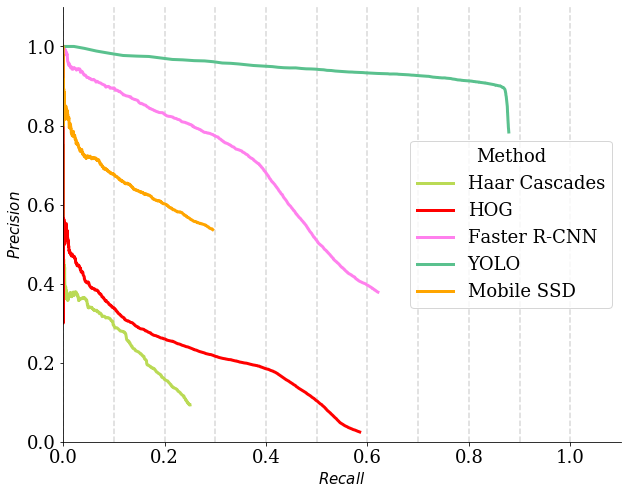

In [58]:
#TEST
scale = 'large'
plt.rcParams["font.size"] = "18"

ax = None
for idx, technique in enumerate(name_map.keys()):
    with open(main_dir + '/results/VIRAT_videos_{}_moving_predicted_boxes.json'.format(technique)) as infile:
        pred_boxes = json.load(infile)
        

    data = get_avg_precision_at_iou(moving_gt_boxes.copy(), pred_boxes.copy(), iou_thr=0.5,
                                scale=scale, name=pickle_map[technique], use_pickle=True)
       
    if ax is None:
        plt.figure(figsize=(10,8))
        ax = plt.gca()

    if color is None:
        color = COLORS[0]
    #ax.scatter(recalls, precisions, label=label, s=10, color=color)
    ax.plot(data['recalls'], data['precisions'],  label=name_map[technique],  linewidth=3, markersize=1, color=COLORS[idx])
    ax.set_xlabel(r'$Recall$', fontsize=15)
    ax.set_ylabel(r'$Precision$', fontsize=15)
    #ax.set_title(title)
    ax.set_xlim([0.0,1.1])
    ax.set_ylim([0.0,1.1])

plt.legend(loc='center right', title='Method', frameon=True, markerscale=3)
for xval in np.linspace(0.0, 1.0, 11):
    plt.vlines(xval, 0.0, 1.1, color='gray', alpha=0.3, linestyles='dashed')
plt.show() 

## PR Curve

Number of all ground truth boxes: 699742
Number of all ground truth boxes: 699742
Number of all ground truth boxes: 699742
Number of all ground truth boxes: 699742
Number of all ground truth boxes: 699742


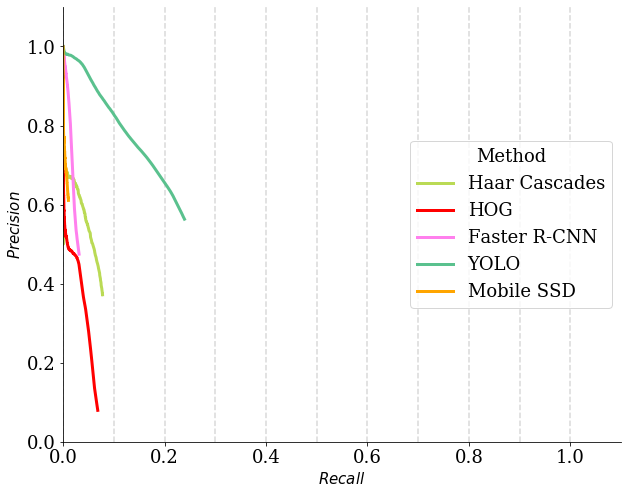

In [59]:
scale = 'all'
plt.rcParams["font.size"] = "18"

ax = None
for idx, technique in enumerate(name_map.keys()):
    with open(main_dir + '/results/VIRAT_videos_{}_moving_predicted_boxes.json'.format(technique)) as infile:
        pred_boxes = json.load(infile)
        

    data = get_avg_precision_at_iou(moving_gt_boxes.copy(), pred_boxes.copy(), iou_thr=0.5,
                                scale=scale, name=pickle_map[technique], use_pickle=True)
       
    
    ax = plot_pr_curve(data['precisions'], data['recalls'], label=name_map[technique], title='Precision-Recall Curve - AP .5', color=COLORS[idx], ax=ax)

plt.legend(loc='center right', title='Method', frameon=True, markerscale=3)
for xval in np.linspace(0.0, 1.0, 11):
    plt.vlines(xval, 0.0, 1.1, color='gray', alpha=0.3, linestyles='dashed')
plt.savefig('PRall.png')  

    

Number of small ground truth boxes: 199357
Number of small ground truth boxes: 199357
Number of small ground truth boxes: 199357
Number of small ground truth boxes: 199357
Number of small ground truth boxes: 199357


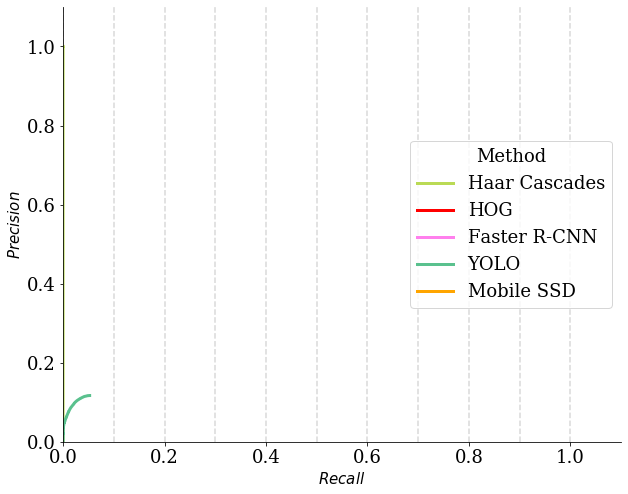

In [60]:
scale = 'small'

ax = None
for idx, technique in enumerate(name_map.keys()):
    with open(main_dir + '/results/VIRAT_videos_{}_moving_predicted_boxes.json'.format(technique)) as infile:
        pred_boxes = json.load(infile)
        

    data = get_avg_precision_at_iou(moving_gt_boxes.copy(), pred_boxes.copy(), iou_thr=0.5,
                                scale=scale, name=pickle_map[technique], use_pickle=True)
       
    
    ax = plot_pr_curve(data['precisions'], data['recalls'], label=name_map[technique], title='Precision-Recall Curve - AP small', color=COLORS[idx], ax=ax)

plt.legend(loc='center right', title='Method', frameon=True, markerscale=3)
for xval in np.linspace(0.0, 1.0, 11):
    plt.vlines(xval, 0.0, 1.1, color='gray', alpha=0.3, linestyles='dashed')

plt.savefig('PRsmall.png')    


Number of medium ground truth boxes: 480833
Number of medium ground truth boxes: 480833
Number of medium ground truth boxes: 480833
Number of medium ground truth boxes: 480833
Number of medium ground truth boxes: 480833


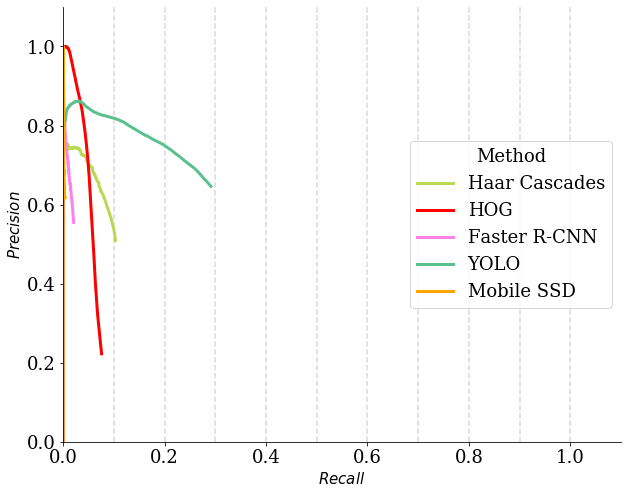

In [61]:
scale = 'medium'

ax = None
for idx, technique in enumerate(name_map.keys()):
    with open(main_dir + '/results/VIRAT_videos_{}_moving_predicted_boxes.json'.format(technique)) as infile:
        pred_boxes = json.load(infile)
        

    data = get_avg_precision_at_iou(moving_gt_boxes.copy(), pred_boxes.copy(), iou_thr=0.5,
                                scale=scale, name=pickle_map[technique], use_pickle=True)
       
    
    ax = plot_pr_curve(data['precisions'], data['recalls'], label=name_map[technique], title='Precision-Recall Curve - AP medium', color=COLORS[idx], ax=ax)

plt.legend(loc='center right', title='Method', frameon=True, markerscale=3)
for xval in np.linspace(0.0, 1.0, 11):
    plt.vlines(xval, 0.0, 1.1, color='gray', alpha=0.3, linestyles='dashed') 
plt.savefig('PRmedium.png') 


Number of large ground truth boxes: 19552
Number of large ground truth boxes: 19552
Number of large ground truth boxes: 19552
Number of large ground truth boxes: 19552
Number of large ground truth boxes: 19552


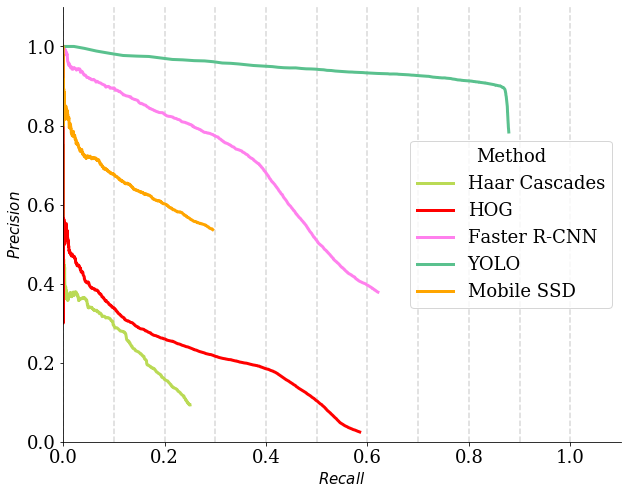

In [62]:
scale = 'large'

ax = None
for idx, technique in enumerate(name_map.keys()):
    with open(main_dir + '/results/VIRAT_videos_{}_moving_predicted_boxes.json'.format(technique)) as infile:
        pred_boxes = json.load(infile)
        

    data = get_avg_precision_at_iou(moving_gt_boxes.copy(), pred_boxes.copy(), iou_thr=0.5,
                                scale=scale, name=pickle_map[technique], use_pickle=True)
       
    
    ax = plot_pr_curve(data['precisions'], data['recalls'], label=name_map[technique], title='Precision-Recall Curve - AP large', color=COLORS[idx], ax=ax)

plt.legend(loc='center right', title='Method', frameon=True,  markerscale=3)
for xval in np.linspace(0.0, 1.0, 11):
    plt.vlines(xval, 0.0, 1.1, color='gray', alpha=0.3, linestyles='dashed')
plt.savefig('PRlarge.png') 
  


## AP x FPS

In [63]:
fps_dict = {'hog_confidence': 2.19, 'haar_confidence': 15.83, 'faster_rcnn': 4.01, 'yolo':6.93, 'mobile_ssd':34.89}

In [64]:
plt.rcParams.update({'font.size': 22})

In [65]:
name_map.keys()

dict_keys(['haar_confidence', 'hog_confidence', 'faster_rcnn', 'yolo', 'mobile_ssd'])

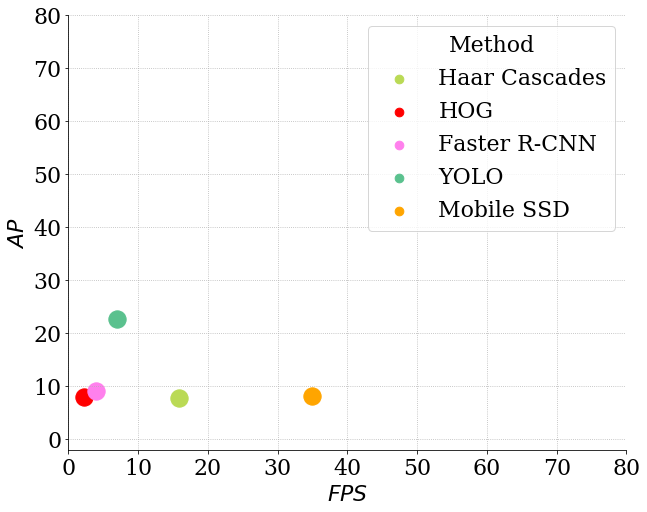

In [66]:
ax = None
scale = 'all'

for idx, technique in enumerate(name_map.keys()):

    if ax is None:
        plt.figure(figsize=(10,8))
        ax = plt.gca()
    
    color = COLORS[idx]   

    ap = manual_map_dict[technique][scale]
        
    ax.scatter(fps_dict[technique], ap, label=name_map[technique], s=300, color=color)
    ax.set_xlabel(r'$FPS$')
    ax.set_ylabel(r'$AP$')
    ax.set_xlim([0,80])
    ax.set_ylim([-2,80])
plt.legend(loc='upper right', title='Method', frameon=True, markerscale=0.5)
plt.grid(linestyle='dotted')
plt.savefig('APxFPS.png')

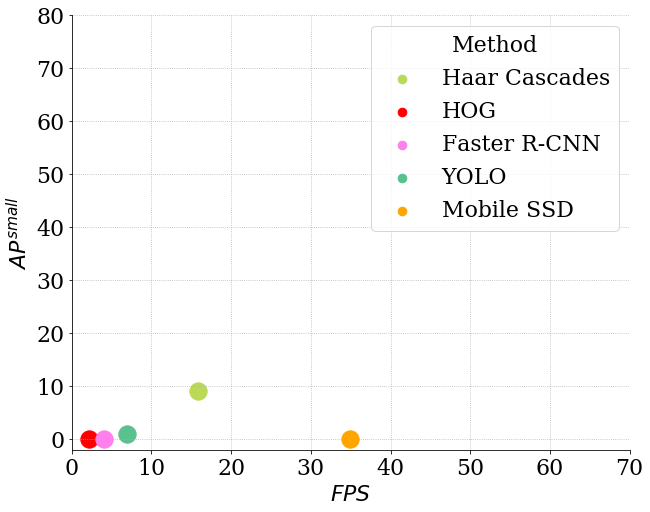

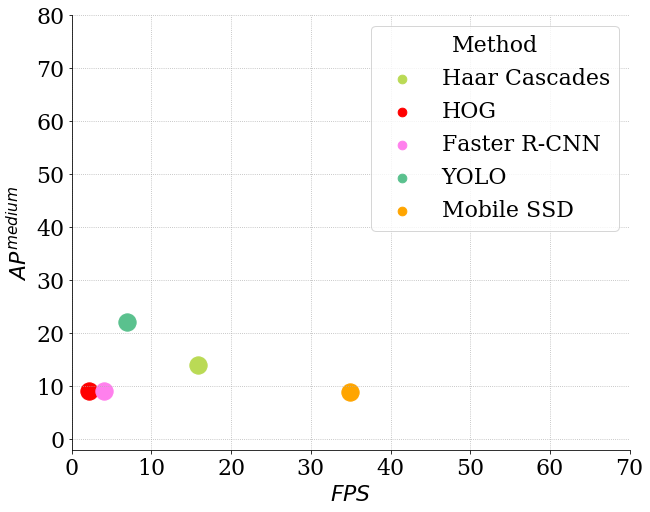

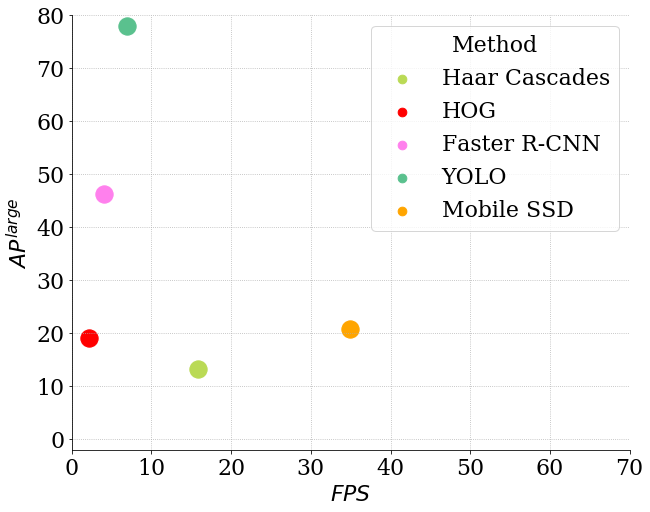

In [67]:
for scale in ['small','medium','large']:

    ax = None

    for idx, technique in enumerate(name_map.keys()):

        if ax is None:
            plt.figure(figsize=(10,8))
            ax = plt.gca()

        color = COLORS[idx]   

        ap = manual_map_dict[technique][scale]

        ax.scatter(fps_dict[technique], ap, label=name_map[technique], s=300, color=color)
        ax.set_xlabel(r'$FPS$')
        ax.set_ylabel(r'$AP^{' + scale + '}$')
        ax.set_xlim([0,70])
        ax.set_ylim([-2,80])
    plt.legend(loc='upper right', title='Method', frameon=True, markerscale=0.5)
    plt.grid(linestyle='dotted')
    plt.savefig('AP' + scale +'xFPS.png')